In [2]:
# all necessary python packages are imported here

from pprint import pprint
import shutil
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy
import rasterio
import geopandas as gpd
from rasterio import features
from shapely.geometry import shape
from datetime import datetime
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import exp, mgrid, signal, row_stack, column_stack, tile, misc
from osgeo import gdal
from scipy.interpolate import griddata
from scipy import interpolate
from shapely.geometry import Point
from scipy.interpolate import Rbf
from matplotlib import cm
import math
from datetime import date,timedelta
#import gdal # Import GDAL library bindings
from osgeo import gdal
%matplotlib inline

C:\Users\nanzu\anaconda3\envs\geoenvet\lib\site-packages\pysheds\sgrid.py:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _OLD_PYPROJ = LooseVersion(pyproj.__version__) < LooseVersion('2.2')
C:\Users\nanzu\anaconda3\envs\geoenvet\lib\site-packages\pysheds\sgrid.py:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _OLD_PYPROJ = LooseVersion(pyproj.__version__) < LooseVersion('2.2')
C:\Users\nanzu\anaconda3\envs\geoenvet\lib\site-packages\pysheds\sview.py:14: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _OLD_PYPROJ = LooseVersion(pyproj.__version__) < LooseVersion('2.2')
C:\Users\nanzu\anaconda3\envs\geoenvet\lib\site-packages\pysheds\sview.py:14: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _OLD_PYPROJ = LooseVersion(pyproj.__version__) < LooseVersion('2.2')
C:\Users\nanzu\anaconda3\envs\ge

### Set up directories, basic model properties

<font color="blue">Paths to different types of input file are set here. This makes paths to individual files shorter later on. 

Essential model parameters (number of layers, grid size) are also set.

In [3]:
#MOD_pth = os.path.join('Input','ArcGIS','Originaldaten','USGS','MOD16A2')
MOD16A2GF_pth = os.path.join('Input','Modis_ET_8days')
subbasin_shp_fn = os.path.join('shp','subbasins.shp')
#et_tifs = os.path.join(swat_pth,"Israel_MOD16A2_TIF")
output = os.path.join('Output','SWE27_V4')

# <font color="red">Reading in a layer from .hdf files

Rasterio (which was used above for .tif files) doesn't seem to have full support for .hdfs, so I've used gdal instead. 
Code snippets taken from http://www2.geog.ucl.ac.uk/~plewis/geogg122_local/geogg122.old/Chapter4_GDAL/GDAL_HDF.html

In [4]:
subbasin_shp = gpd.read_file(subbasin_shp_fn)
subbasin_shp = subbasin_shp.to_crs({'init':'epsg:25833'})

In [5]:
# open a reference raster to get the dimensions needed for all model input rasters
rst_fn = os.path.join('Input_p','MOD_ET_2000001.tif')
with rasterio.open(rst_fn) as rst:
    nrow, ncol = rst.read(1).shape
    meta = rst.meta
    crs = meta['crs']
    vals = rst.read(1)
    nodata = meta['nodata']
    dtype = meta['dtype']
    ET = rst.read(1)
    

In [6]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 32767.0,
 'width': 2400,
 'height': 2400,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(463.3127165416667, 0.0, 0.0,
        0.0, -463.3127165416667, 6671703.118)}

In [7]:
#subbasin_shp = gpd.read_file(subbasin_shp_fn)
#subbasin_shp = subbasin_shp.to_crs({'init':'epsg:25833'})

In [8]:
#subbasin_shp = gpd.read_file(subbasin_shp_fn)
#subbasin_shp = subbasin_shp.to_crs({'init':'epsg:25833'})
out_fn = 'subbasins.tif'
# save recharge polys tif
with rasterio.open(out_fn+'.tif', 'w', **meta) as out:
    # this is where we create a generator of geom, value pairs to use in rasterizing
    # 'geom' is the geometry of the polygon, while value in this case is the recharge zone number
    try:
        shapes = ((geom,value) for geom, value in zip(subbasin_shp.geometry, subbasin_shp['Subbasin']))
    except:
        shapes = ((geom,value) for geom, value in zip(subbasin_shp.geometry, subbasin_shp['Subbasin']))
    subbasins_rst = features.rasterize(shapes=shapes, fill=0, out_shape=rst.shape, transform=out.transform)
    
    # save tif file
    out.write_band(1, subbasins_rst.astype(dtype))
    # save text file for modflow input
    np.savetxt(out_fn+'.ref',subbasins_rst.astype(dtype),fmt='%i')

<Axes: >

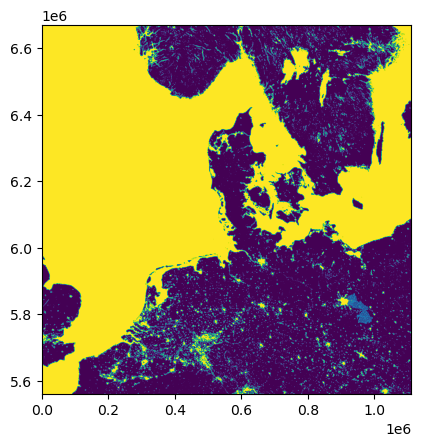

In [9]:
from rasterio.plot import show


subbasin_shp = gpd.read_file(subbasin_shp_fn)
subbasin_shp = subbasin_shp.to_crs(crs)

# open a reference raster to get the dimensions needed for all model input rasters
rst_fn = os.path.join('Input_p','MOD_ET_2000001.tif')
rst =  rasterio.open(rst_fn)


fig,ax = plt.subplots()

show(rst.read(), transform=rst.transform,ax=ax)  
subbasin_shp.plot(ax=ax)

In [10]:
from osgeo import gdal # Import GDAL library bindings

Read in all of the .hdf files from the specified path (reads recursively - i.e. looks in all subfolders)

In [11]:
if "h18v03" in "MOD16A2GF.A2000001.h18v03.061.2020256103505.hdf":
    print("fifi")

fifi


In [134]:
filenames = []
for r, d, f in os.walk(MOD16A2GF_pth):
    for file in f:
        if file.endswith('.hdf') and "h18v03" in file:
        #if '.hdf' in file:
        #if file.endswith('.hdf_2.ovr'):
            filenames.append(os.path.join(r, file))
filenames

['Input\\Modis_ET_8days\\MOD16A2GF.A2000001.h18v03.061.2020256103505.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000009.h18v03.061.2020256123417.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000017.h18v03.061.2020256151004.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000025.h18v03.061.2020256172552.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000033.h18v03.061.2020256195249.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000041.h18v03.061.2020256223427.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000049.h18v03.061.2020257004059.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000057.h18v03.061.2020257034707.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000065.h18v03.061.2020257073230.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000073.h18v03.061.2020257100222.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000081.h18v03.061.2020257124504.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000089.h18v03.061.2020257154744.hdf',
 'Input\\Modis_ET_8days\\MOD16A2GF.A2000097.h18v03.061.2020257182317.hdf',
 'Input\\Modis_ET_8days\\

In [135]:
#filenames = filenames[:5]
#filenames

Loop through all identified hdf files and read the data. Extract the layer of interest from the hdf file. Re-rasterize the subbasins shapefile on the same grid as the hdf file. Then loop through all of the subbasins in the shapefile and mask the hdf data so that only the pixels within each subbasin are retained. Find the average of the retained pixels (for the subbasin) and enter into a pandas DataFrame. 

In [136]:
# open a reference raster to get the dimensions needed for all model input rasters
ET_mean = pd.DataFrame()
ET_median = pd.DataFrame()
ET_median = pd.DataFrame()
ET_count = pd.DataFrame()
ET_count_total = pd.DataFrame()


# for convenience, we will use string substitution to create a 
# template for GDAL filenames, which we'll substitute on the fly:
file_template = 'HDF4_EOS:EOS_GRID:{:s}:MOD_Grid_MOD16A2:{:s}'
# name of layer to extract from hdf file
layer = "ET_500m"

# extract subbasin geometries from shapefile (only need to do this once as shapefile does not change)
shapes = ((geom,value) for geom, value in zip(subbasin_shp.geometry, subbasin_shp['Subbasin']))

# get shape of first raster to set initial raster
filename = filenames[0]
this_file = file_template.format(filename,layer)
g = gdal.Open(this_file)
arr = g.ReadAsArray() 
arr_shape = arr.shape
transform = g.GetGeoTransform()
if rasterio.transform.tastes_like_gdal(transform):
    c, a, b, f, d, e = transform
    #print(rasterio.Affine.from_gdal(c, a, b, f, d, e))
    affine = rasterio.Affine.from_gdal(c, a, b, f, d, e)
    
subbasins_rst = features.rasterize(shapes=shapes, fill=0, out_shape=arr_shape, transform=affine)

for filename in filenames:
    yearday = filename.split('.')[-5][1:]
    year = yearday[:4]
    day = yearday[4:]
    date = pd.to_datetime(yearday,format='%Y%j')
    
    # read the file and layer
    this_file = file_template.format(filename,layer)
    g = gdal.Open(this_file)
    if g is None:
        raise IOError
    # extract the data
    arr = g.ReadAsArray()

    # if the shape of this file does not match the shape of the previous file, update the subbasins raster
    # doing this in an if statement saves some computation as it will only update when necessary
    if arr.shape!=arr_shape or g.GetGeoTransform()!=transform:
        arr_shape = arr.shape
        # get the raster transform (info on origin and pixel size) 
        transform = g.GetGeoTransform()
        if rasterio.transform.tastes_like_gdal(transform):
            c, a, b, f, d, e = transform
            #print(rasterio.Affine.from_gdal(c, a, b, f, d, e))
            affine = rasterio.Affine.from_gdal(c, a, b, f, d, e)
        subbasins_rst = features.rasterize(shapes=shapes, fill=0, out_shape=arr_shape, transform=affine)
        

    #break
    for sb in subbasin_shp.Subbasin:
        ET_in_sb = np.where(subbasins_rst==sb,arr,np.nan)
        ET_in_sb = np.where(ET_in_sb < 32761,ET_in_sb,np.nan)
        ET_mean.loc[sb,date] = np.nanmean(ET_in_sb)
        ET_median.loc[sb,date] = np.nanmedian(ET_in_sb)
        ET_count.loc[sb,date] = (~np.isnan(ET_in_sb)).astype(int).sum()
        ET_count_total.loc[sb,date] = np.sum(subbasins_rst==sb)
        ET_ratio_active_cells = ET_count / ET_count_total
        
        if ((~np.isnan(ET_in_sb)).astype(int).sum() / np.sum(subbasins_rst==sb) > 0.1):
 
            ET_mean.loc[sb,date] = np.nanmean(ET_in_sb)*0.1
            ET_median.loc[sb,date] = np.nanmedian(ET_in_sb)*0.1
        else:
            
            ET_mean.loc[sb,date] = float("nan")
            ET_median.loc[sb,date] = float("nan")  
        
    #break

Check that raster of subbasins contains expected values (i.e. all/most sub-basins)

In [137]:
np.unique(subbasins_rst)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112], dtype=uint8)

Display results

Save results to file

<font color="blue">**transpose the mean and median matrix to get the subbasins into the header and dates into indexes**


In [138]:
ET_mean.sort_index(inplace=True)
ET_per_sub_mean = ET_mean.T
ET_per_sub_mean

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
2000-01-01,1.694872,1.783333,1.945455,1.847727,1.905634,1.784459,2.018750,1.970732,2.033333,2.108955,...,1.962791,1.839106,1.932662,2.096032,2.054260,1.9800,1.864571,1.812925,1.772174,1.955233
2000-01-09,1.741026,1.823333,2.022727,1.938636,1.998592,1.815541,2.046875,2.096341,2.216667,2.247761,...,1.931977,1.785475,1.904560,2.033333,2.042152,1.9240,1.857714,1.752041,1.717391,1.930814
2000-01-17,2.617949,2.710000,3.022727,2.917424,3.042254,2.679730,2.996875,3.223171,3.400000,3.461194,...,2.533140,2.307263,2.480170,2.585714,2.650224,2.4712,2.457714,2.264626,2.186087,2.502326
2000-01-25,2.741026,2.863333,3.213636,3.069697,3.246479,2.876351,3.243750,3.421951,3.583333,3.631343,...,3.112791,2.847486,3.053977,3.196032,3.269955,3.0520,3.012571,2.797959,2.704348,3.097093
2000-02-02,3.458974,3.546667,3.936364,3.782576,3.909859,3.512162,3.956250,4.089024,4.283333,4.374627,...,3.747674,3.462011,3.691410,3.888095,3.951121,3.7184,3.624571,3.400340,3.307826,3.744767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,2.300000,1.956667,2.238636,2.162879,2.480282,2.011486,2.190625,2.335366,2.516667,2.434328,...,2.886047,2.526257,2.268399,2.326984,2.450224,2.3128,2.284571,2.448980,2.160000,2.219767
2021-12-03,2.123077,1.783333,2.170455,2.031061,2.319718,1.868243,2.115625,2.152439,2.400000,2.291045,...,2.878488,2.539106,2.161612,2.208730,2.302691,2.2336,2.296571,2.514286,2.180000,2.155233
2021-12-11,1.494872,1.290000,1.484091,1.396212,1.518310,1.339865,1.453125,1.373171,1.333333,1.400000,...,1.320349,1.440782,1.472853,1.484921,1.550673,1.4888,1.447429,1.334354,1.386957,1.488953
2021-12-19,1.992308,1.813333,2.154545,1.960606,1.997183,1.827027,2.178125,2.015854,2.550000,2.397015,...,3.017442,2.478771,2.113680,2.176984,2.334081,2.1496,2.243429,2.618367,2.144348,2.103488


<font color="blue">**Interpolate by surrounding values of MEAN, if a value is NaN**

In [139]:
for sub in range(0,ET_per_sub_mean.shape[1]):
    for ti in range(0,ET_per_sub_mean.shape[0]):
        if ((np.isnan(ET_per_sub_mean.iloc[ti,sub])) & (ti>0) & (ti<ET_per_sub_mean.shape[0]-1)):
            ET_per_sub_mean.iloc[ti,sub] = np.nanmean([ET_per_sub_mean.iloc[ti-1,sub],ET_per_sub_mean.iloc[ti+1,sub]])
            #If surrounded by NaNs we take an average of the whole column
            if np.isnan(ET_per_sub_mean.iloc[ti,sub]):
                ET_per_sub_mean.iloc[ti,sub] = np.nanmean(ET_per_sub_mean.iloc[:,sub])

In [140]:
ET_per_sub_mean

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
2000-01-01,1.694872,1.783333,1.945455,1.847727,1.905634,1.784459,2.018750,1.970732,2.033333,2.108955,...,1.962791,1.839106,1.932662,2.096032,2.054260,1.9800,1.864571,1.812925,1.772174,1.955233
2000-01-09,1.741026,1.823333,2.022727,1.938636,1.998592,1.815541,2.046875,2.096341,2.216667,2.247761,...,1.931977,1.785475,1.904560,2.033333,2.042152,1.9240,1.857714,1.752041,1.717391,1.930814
2000-01-17,2.617949,2.710000,3.022727,2.917424,3.042254,2.679730,2.996875,3.223171,3.400000,3.461194,...,2.533140,2.307263,2.480170,2.585714,2.650224,2.4712,2.457714,2.264626,2.186087,2.502326
2000-01-25,2.741026,2.863333,3.213636,3.069697,3.246479,2.876351,3.243750,3.421951,3.583333,3.631343,...,3.112791,2.847486,3.053977,3.196032,3.269955,3.0520,3.012571,2.797959,2.704348,3.097093
2000-02-02,3.458974,3.546667,3.936364,3.782576,3.909859,3.512162,3.956250,4.089024,4.283333,4.374627,...,3.747674,3.462011,3.691410,3.888095,3.951121,3.7184,3.624571,3.400340,3.307826,3.744767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,2.300000,1.956667,2.238636,2.162879,2.480282,2.011486,2.190625,2.335366,2.516667,2.434328,...,2.886047,2.526257,2.268399,2.326984,2.450224,2.3128,2.284571,2.448980,2.160000,2.219767
2021-12-03,2.123077,1.783333,2.170455,2.031061,2.319718,1.868243,2.115625,2.152439,2.400000,2.291045,...,2.878488,2.539106,2.161612,2.208730,2.302691,2.2336,2.296571,2.514286,2.180000,2.155233
2021-12-11,1.494872,1.290000,1.484091,1.396212,1.518310,1.339865,1.453125,1.373171,1.333333,1.400000,...,1.320349,1.440782,1.472853,1.484921,1.550673,1.4888,1.447429,1.334354,1.386957,1.488953
2021-12-19,1.992308,1.813333,2.154545,1.960606,1.997183,1.827027,2.178125,2.015854,2.550000,2.397015,...,3.017442,2.478771,2.113680,2.176984,2.334081,2.1496,2.243429,2.618367,2.144348,2.103488


<font color="blue">**Calculate the length of each timestep in a list (delta) and divide the sum of the mostly 8 day intervals to daily values [mm/d]**

In [141]:
TO = ET_per_sub_mean.index.values.astype('datetime64[D]')
TI = np.arange(TO[0],TO[np.size(TO)-1],np.timedelta64(1,'D'))
delta = []

for i in range(len(TO)):
    if i < len(TO)-1:
        delta.append((TO[i+1]-TO[i]).astype(int))
    else:
        delta.append(8)
        
ET_per_sub_mean_8days = pd.DataFrame()          #Daily means, the values in the 8day timestep are in mm/d

for sub in list(ET_per_sub_mean.columns):   
    ET_per_sub_mean_8days[sub] = ET_per_sub_mean[sub]/delta

ET_per_sub_mean_8days

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
2000-01-01,0.211859,0.222917,0.243182,0.230966,0.238204,0.223057,0.252344,0.246341,0.254167,0.263619,...,0.245349,0.229888,0.241583,0.262004,0.256783,0.2475,0.233071,0.226616,0.221522,0.244404
2000-01-09,0.217628,0.227917,0.252841,0.242330,0.249824,0.226943,0.255859,0.262043,0.277083,0.280970,...,0.241497,0.223184,0.238070,0.254167,0.255269,0.2405,0.232214,0.219005,0.214674,0.241352
2000-01-17,0.327244,0.338750,0.377841,0.364678,0.380282,0.334966,0.374609,0.402896,0.425000,0.432649,...,0.316642,0.288408,0.310021,0.323214,0.331278,0.3089,0.307214,0.283078,0.273261,0.312791
2000-01-25,0.342628,0.357917,0.401705,0.383712,0.405810,0.359544,0.405469,0.427744,0.447917,0.453918,...,0.389099,0.355936,0.381747,0.399504,0.408744,0.3815,0.376571,0.349745,0.338043,0.387137
2000-02-02,0.432372,0.443333,0.492045,0.472822,0.488732,0.439020,0.494531,0.511128,0.535417,0.546828,...,0.468459,0.432751,0.461426,0.486012,0.493890,0.4648,0.453071,0.425043,0.413478,0.468096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,0.287500,0.244583,0.279830,0.270360,0.310035,0.251436,0.273828,0.291921,0.314583,0.304291,...,0.360756,0.315782,0.283550,0.290873,0.306278,0.2891,0.285571,0.306122,0.270000,0.277471
2021-12-03,0.265385,0.222917,0.271307,0.253883,0.289965,0.233530,0.264453,0.269055,0.300000,0.286381,...,0.359811,0.317388,0.270201,0.276091,0.287836,0.2792,0.287071,0.314286,0.272500,0.269404
2021-12-11,0.186859,0.161250,0.185511,0.174527,0.189789,0.167483,0.181641,0.171646,0.166667,0.175000,...,0.165044,0.180098,0.184107,0.185615,0.193834,0.1861,0.180929,0.166794,0.173370,0.186119
2021-12-19,0.249038,0.226667,0.269318,0.245076,0.249648,0.228378,0.272266,0.251982,0.318750,0.299627,...,0.377180,0.309846,0.264210,0.272123,0.291760,0.2687,0.280429,0.327296,0.268043,0.262936


<font color="blue">Calculate the interpolated daily data of MEAN and check that the size of the indexes are the same

In [142]:
Mean_Daily_frame = np.zeros([np.size(TI),ET_per_sub_mean_8days.shape[1]])
for sub in range(0,ET_per_sub_mean_8days.shape[1]):
    
    #f = scipy.interpolate.interp1d(TO,ET_per_sub.iloc[:,sub])
    Mean_Daily_frame[:,sub] = np.interp(TI.astype(int),TO.astype(int),ET_per_sub_mean_8days.iloc[:,sub])  

if Mean_Daily_frame.shape[0] == (ET_per_sub_mean.index[-1]-ET_per_sub_mean.index[0]).days:
    print("Die Anzahl der Interpolierten Tage ist korrekt.")

Die Anzahl der Interpolierten Tage ist korrekt.


In [143]:
TD = np.arange(np.datetime64('2000-01-01'),np.datetime64('2021-12-27'),np.timedelta64(1,'D'))
ET_per_sub_mean_daily = pd.DataFrame(Mean_Daily_frame.round(3),index = TD,columns=ET_per_sub_mean.columns)
ET_per_sub_mean_daily.to_csv(os.path.join(output,'ET_mean_by_subbasin_day.csv'))
ET_per_sub_mean_daily

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
2000-01-01,0.212,0.223,0.243,0.231,0.238,0.223,0.252,0.246,0.254,0.264,...,0.245,0.230,0.242,0.262,0.257,0.248,0.233,0.227,0.222,0.244
2000-01-02,0.213,0.224,0.244,0.232,0.240,0.224,0.253,0.248,0.257,0.266,...,0.245,0.229,0.241,0.261,0.257,0.247,0.233,0.226,0.221,0.244
2000-01-03,0.213,0.224,0.246,0.234,0.241,0.224,0.253,0.250,0.260,0.268,...,0.244,0.228,0.241,0.260,0.256,0.246,0.233,0.225,0.220,0.244
2000-01-04,0.214,0.225,0.247,0.235,0.243,0.225,0.254,0.252,0.263,0.270,...,0.244,0.227,0.240,0.259,0.256,0.245,0.233,0.224,0.219,0.243
2000-01-05,0.215,0.225,0.248,0.237,0.244,0.225,0.254,0.254,0.266,0.272,...,0.243,0.227,0.240,0.258,0.256,0.244,0.233,0.223,0.218,0.243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-22,0.210,0.192,0.227,0.207,0.211,0.193,0.228,0.210,0.261,0.248,...,0.313,0.262,0.227,0.233,0.249,0.230,0.240,0.274,0.230,0.227
2021-12-23,0.197,0.180,0.213,0.194,0.199,0.181,0.213,0.196,0.242,0.231,...,0.291,0.246,0.214,0.220,0.235,0.218,0.226,0.257,0.217,0.214
2021-12-24,0.184,0.169,0.199,0.181,0.186,0.169,0.198,0.182,0.222,0.214,...,0.270,0.230,0.202,0.207,0.221,0.205,0.212,0.239,0.204,0.202
2021-12-25,0.171,0.157,0.185,0.168,0.173,0.157,0.183,0.168,0.203,0.197,...,0.248,0.214,0.189,0.194,0.207,0.192,0.199,0.221,0.191,0.190


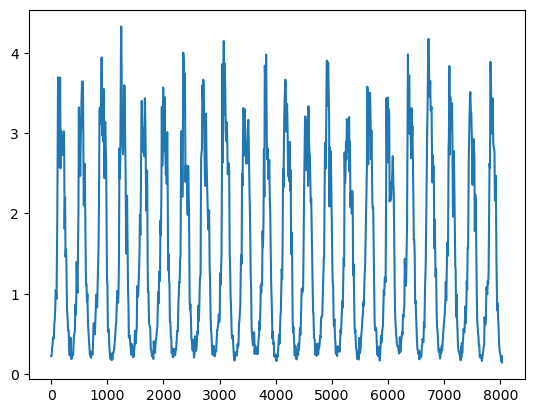

In [144]:
plt.plot(Mean_Daily_frame[:,1])

In [145]:
Mean_Daily_frame.shape

(8031, 112)

<font color="blue">**Calculate the monthly values of MEAN from daily values by summing up values with the same year and month [:7] per subbasin**

In [146]:
TM = np.arange(np.datetime64('2000-01'),np.datetime64('2021-01'),np.timedelta64(1,'M'))
Mean_Monthly_frame = np.zeros([np.size(TM),ET_per_sub_mean.shape[1]])

for sub in range(0,ET_per_sub_mean.shape[1]):
    for i in range(0,np.size(TM)):
        indexstr = TM[i].astype(str)
        A = 0
        for t in range(0,np.size(TI)):
            
            if (indexstr == TI[t].astype(str)[:7]):
                A = A + Mean_Daily_frame[t,sub]
            Mean_Monthly_frame[i,sub] = A

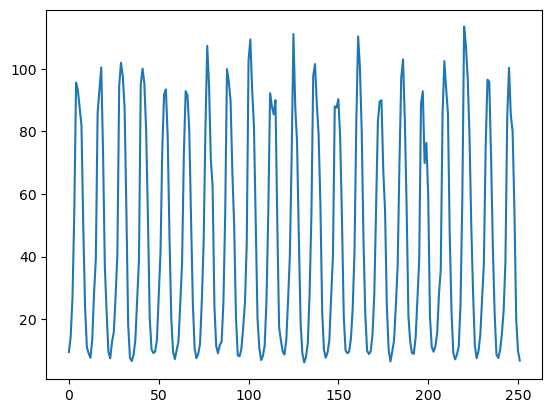

In [147]:
plt.plot(Mean_Monthly_frame[:,1])

In [148]:
Mean_Monthly_frame.shape

(252, 112)

<font color="blue">**Creating a dataframe for the monthly values of MEAN per subbasin**

In [149]:
ET_per_sub_mean_monthly = pd.DataFrame(Mean_Monthly_frame.round(3),index = TM,columns=ET_per_sub_mean.columns)
ET_per_sub_mean_monthly

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
2000-01-01,9.146,9.519,10.595,10.158,10.591,9.483,10.671,11.138,11.693,11.905,...,9.863,9.066,9.689,10.220,10.363,9.733,9.519,8.906,8.648,9.810
2000-02-01,13.602,14.435,15.523,15.174,15.678,14.177,15.550,16.241,17.122,17.365,...,14.094,13.012,13.856,14.257,14.665,13.823,13.764,12.901,12.444,14.024
2000-03-01,25.605,26.844,27.743,27.508,27.219,25.286,27.328,26.783,28.281,28.842,...,24.607,23.391,24.996,25.318,26.399,24.825,24.145,23.101,23.324,24.757
2000-04-01,47.790,54.148,53.798,52.352,57.601,52.750,68.444,55.373,53.475,52.979,...,51.063,50.239,51.592,56.650,52.490,49.539,49.902,43.790,45.153,47.031
2000-05-01,67.299,95.584,71.012,77.096,82.114,90.371,100.066,85.374,72.838,72.302,...,64.942,67.219,70.021,76.953,74.632,67.641,73.588,57.345,62.314,63.903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,59.895,79.993,36.763,51.657,47.462,71.667,37.020,51.151,43.923,43.462,...,52.628,59.957,59.934,53.334,56.166,60.968,67.486,64.769,60.007,61.762
2020-09-01,44.636,55.025,32.071,41.628,36.217,50.853,29.997,37.312,38.075,33.816,...,40.454,44.681,46.545,43.124,47.564,48.546,51.242,47.805,47.511,48.626
2020-10-01,21.305,19.901,22.312,22.732,22.462,20.650,22.653,22.126,22.113,22.324,...,22.617,21.444,22.468,23.453,24.107,22.598,21.947,20.415,21.291,22.483
2020-11-01,11.062,9.827,11.968,12.224,12.131,10.160,11.874,11.261,11.162,11.641,...,12.418,11.602,11.903,12.575,13.527,12.557,11.387,10.389,11.162,12.018


<font color="blue">**Creating a dataframe for EVERY Subbasin with monthly values of MEAN**

In [150]:
start2000 = os.path.join('Output','Subs112','Starting_2000')
start_date = "01.12.1999"
start_date = datetime.strptime(start_date,"%d.%m.%Y")
counter = 0

for sub in ET_per_sub_mean_monthly.columns:
    globals()['df_ET_mean_monthly_sub%s' % sub] = ET_per_sub_mean_monthly.iloc[:,counter:counter+1]
    globals()['df_ET_mean_monthly_sub%s' % sub]["Count"] = (ET_per_sub_mean_monthly.index.year - start_date.year)*12 + ET_per_sub_mean_monthly.index.month - start_date.month
    globals()['df_ET_mean_monthly_sub%s' % sub]["SWATCUP"] = "ET_" + str(sub) + "_" + ET_per_sub_mean_monthly.index.strftime("%Y.%m")
    cols = globals()['df_ET_mean_monthly_sub%s' % sub].columns.tolist()
    cols = cols[1:] + cols[:1]
    globals()['df_ET_mean_monthly_sub%s' % sub] = globals()['df_ET_mean_monthly_sub%s' % sub][cols]
    counter = counter + 1
    #globals()['df_ET_mean_monthly_sub%s' % sub].columns = globals()['df_ET_mean_monthly_sub%s' % sub].columns[-1:]+globals()['df_ET_mean_monthly_sub%s' % sub].columns[:-1]
    


In [151]:
df_ET_mean_monthly_sub2

,Count,SWATCUP,2
2000-01-01,1,ET_2_2000.01,9.519
2000-02-01,2,ET_2_2000.02,14.435
2000-03-01,3,ET_2_2000.03,26.844
2000-04-01,4,ET_2_2000.04,54.148
2000-05-01,5,ET_2_2000.05,95.584
...,...,...,...
2020-08-01,248,ET_2_2020.08,79.993
2020-09-01,249,ET_2_2020.09,55.025
2020-10-01,250,ET_2_2020.10,19.901
2020-11-01,251,ET_2_2020.11,9.827


<font color="blue">**Exporting all Mean Dataframes per Subbasin to .csv file**

In [152]:
for i in ET_per_sub_mean_monthly.columns:
    globals()['df_ET_mean_monthly_sub%s' % i].to_csv(os.path.join(output,"df_ET_mean_monthly_sub%s.csv" %i), sep=',')

In [153]:
ET_per_sub_mean_monthly.to_csv(os.path.join(output,'ET_mean_by_subbasin_month.csv'))
#ET_median.to_csv(os.path.join(output,'ET_median_by_subbasin.csv'))
#ET_count.to_csv(os.path.join(output,'ET_count_by_subbasin.csv'))
#ET_ratio_active_cells.to_csv(os.path.join(output,'ET_Ration_Active_cells_by_subbasin.csv'))

In [154]:
#pd.to_datetime(dic[z]['datetime'].dt.strftime('%Y-%m')+'-15')

In [155]:
a = pd.read_csv(os.path.join(output,'ET_mean_by_subbasin_month.csv'),sep=',').set_index('Unnamed: 0')
a.index = pd.to_datetime(a.index)
lst = list(range(4,10))
a[~a.index.month.isin(lst)]

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2000-01-01,9.146,9.519,10.595,10.158,10.591,9.483,10.671,11.138,11.693,11.905,...,9.863,9.066,9.689,10.220,10.363,9.733,9.519,8.906,8.648,9.810
2000-02-01,13.602,14.435,15.523,15.174,15.678,14.177,15.550,16.241,17.122,17.365,...,14.094,13.012,13.856,14.257,14.665,13.823,13.764,12.901,12.444,14.024
2000-03-01,25.605,26.844,27.743,27.508,27.219,25.286,27.328,26.783,28.281,28.842,...,24.607,23.391,24.996,25.318,26.399,24.825,24.145,23.101,23.324,24.757
2000-10-01,23.438,23.861,24.923,24.787,24.705,22.896,25.489,24.269,24.258,24.907,...,23.668,23.086,23.878,25.303,27.334,24.092,24.536,22.074,21.770,24.008
2000-11-01,10.679,11.124,12.255,11.834,12.294,10.560,12.459,11.761,11.822,12.268,...,12.517,11.271,11.809,13.465,13.826,12.564,11.513,10.580,10.823,11.743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,14.376,15.129,16.852,16.150,16.570,14.935,17.158,16.309,17.244,17.886,...,16.236,15.303,15.908,16.555,16.839,15.680,15.199,14.370,14.276,15.740
2020-03-01,21.576,22.711,25.032,23.587,24.395,22.099,24.800,24.320,25.009,25.203,...,24.779,23.651,24.291,25.006,25.712,25.059,23.826,23.597,23.545,24.512
2020-10-01,21.305,19.901,22.312,22.732,22.462,20.650,22.653,22.126,22.113,22.324,...,22.617,21.444,22.468,23.453,24.107,22.598,21.947,20.415,21.291,22.483


In [156]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# <font color="red">Calculate PET from .hdf files

<Axes: >

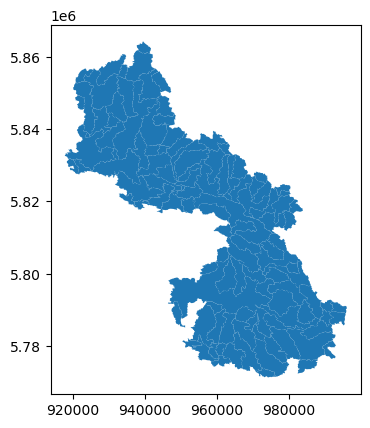

In [12]:
# load in Shapefile
subbasin_shp = gpd.read_file(subbasin_shp_fn)
subbasin_shp = subbasin_shp.to_crs(crs)
# add column on which to dissolve
#subbasin_shp['dissolve'] = len(subbasin_shp)*[1]
#subbasin_shp = subbasin_shp.dissolve(by='dissolve')
subbasin_shp.plot()

In [14]:
# open a reference raster to get the dimensions needed for all model input rasters
PET_mean = pd.DataFrame()
PET_median = pd.DataFrame()
PET_median = pd.DataFrame()
PET_count = pd.DataFrame()
PET_count_total = pd.DataFrame()


# for convenience, we will use string substitution to create a 
# template for GDAL filenames, which we'll substitute on the fly:
file_template = 'HDF4_EOS:EOS_GRID:{:s}:MOD_Grid_MOD16A2:{:s}'
# name of layer to extract from hdf file
layer = "PET_500m"

# extract subbasin geometries from shapefile (only need to do this once as shapefile does not change)
shapes = ((geom,value) for geom, value in zip(subbasin_shp.geometry, subbasin_shp['Subbasin']))

# get shape of first raster to set initial raster
filename = filenames[0]
this_file = file_template.format(filename,layer)
g = gdal.Open(this_file)
arr = g.ReadAsArray() 
arr_shape = arr.shape
transform = g.GetGeoTransform()
if rasterio.transform.tastes_like_gdal(transform):
    c, a, b, f, d, e = transform
    #print(rasterio.Affine.from_gdal(c, a, b, f, d, e))
    affine = rasterio.Affine.from_gdal(c, a, b, f, d, e)
    
subbasins_rst = features.rasterize(shapes=shapes, fill=0, out_shape=arr_shape, transform=affine)

for filename in filenames:
    yearday = filename.split('.')[-5][1:]
    year = yearday[:4]
    day = yearday[4:]
    date = pd.to_datetime(yearday,format='%Y%j')
    
    # read the file and layer
    this_file = file_template.format(filename,layer)
    g = gdal.Open(this_file)
    if g is None:
        raise IOError
    # extract the data
    arr = g.ReadAsArray()

    # if the shape of this file does not match the shape of the previous file, update the subbasins raster
    # doing this in an if statement saves some computation as it will only update when necessary
    if arr.shape!=arr_shape or g.GetGeoTransform()!=transform:
        arr_shape = arr.shape
        # get the raster transform (info on origin and pixel size) 
        transform = g.GetGeoTransform()
        if rasterio.transform.tastes_like_gdal(transform):
            c, a, b, f, d, e = transform
            #print(rasterio.Affine.from_gdal(c, a, b, f, d, e))
            affine = rasterio.Affine.from_gdal(c, a, b, f, d, e)
        subbasins_rst = features.rasterize(shapes=shapes, fill=0, out_shape=arr_shape, transform=affine)
        

    # not really necessary for PET due to only one Subbasin
    for sb in subbasin_shp.Subbasin:
        PET_in_sb = np.where(subbasins_rst==sb,arr,np.nan)
        PET_in_sb = np.where(PET_in_sb < 32761,PET_in_sb,np.nan)
        PET_mean.loc[sb,date] = np.nanmean(PET_in_sb)
        PET_median.loc[sb,date] = np.nanmedian(PET_in_sb)
        PET_count.loc[sb,date] = (~np.isnan(PET_in_sb)).astype(int).sum()
        PET_count_total.loc[sb,date] = np.sum(subbasins_rst==sb)
        PET_ratio_active_cells = PET_count / PET_count_total
        
        # only take values, if more than 10% of Subbasin area is covered by valid cells
        if ((~np.isnan(PET_in_sb)).astype(int).sum() / np.sum(subbasins_rst==sb) > 0.1):
            # Multiply with transformation factor given by Modis             
            PET_mean.loc[sb,date] = np.nanmean(PET_in_sb)*0.1
            PET_median.loc[sb,date] = np.nanmedian(PET_in_sb)*0.1
        else:
            
            PET_mean.loc[sb,date] = float("nan")
            PET_median.loc[sb,date] = float("nan")  
        
    #break

<font color="blue">**transpose the mean and median matrix to get the subbasins into the header and dates into indexes**


In [15]:
PET_mean.sort_index(inplace=True)
PET_per_sub_mean = PET_mean.T
PET_per_sub_mean

,1,2,3,4,5,6,7,8,9,10,...,86,87,88,89,90,91,92,93,94,95
2000-01-01,16.286047,15.797674,15.503333,15.500000,15.353,15.485057,15.720588,14.784783,17.118421,15.234653,...,NaN,15.004167,14.860268,16.926316,15.516667,16.755488,14.916942,16.600000,NaN,16.560504
2000-01-09,17.400000,16.879070,16.683333,16.612121,16.630,16.901149,17.308824,16.368478,18.173684,17.170297,...,NaN,16.804167,16.755134,18.003947,18.366667,18.020732,16.920248,19.071429,NaN,17.761345
2000-01-17,16.060465,15.611628,15.413333,15.345455,15.372,15.681609,16.252941,15.431522,17.355263,16.242574,...,NaN,17.331250,15.913839,20.389474,17.450000,20.227439,16.138430,18.114286,NaN,20.067227
2000-01-25,14.818605,14.555814,14.130000,14.175758,13.982,14.085057,14.329412,13.731522,15.071053,14.353465,...,NaN,14.647917,14.057813,15.852632,16.250000,15.540854,14.078512,15.809524,NaN,15.772689
2000-02-02,20.723256,20.223256,19.793333,20.030303,19.834,19.971264,20.255882,19.278261,21.650000,20.369307,...,NaN,19.685417,19.938839,19.111842,23.716667,18.982927,20.025207,22.852381,NaN,18.945378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25,30.823256,30.653488,29.840000,30.927273,30.767,30.827586,31.232353,30.378261,33.171053,30.426733,...,NaN,30.422917,30.486830,32.093421,29.183333,32.692073,31.373967,30.747619,NaN,32.178571
2019-12-03,24.797674,24.774419,23.476667,24.666667,24.616,24.565517,25.000000,24.167391,25.236842,24.056436,...,NaN,23.472917,24.128571,23.917105,23.216667,23.916463,24.559504,23.900000,NaN,23.904622
2019-12-11,23.646512,23.230233,22.820000,23.627273,23.321,23.233333,23.694118,22.614130,24.989474,22.276238,...,NaN,23.183333,22.331920,24.877632,21.983333,25.126220,22.856198,22.523810,NaN,24.778571
2019-12-19,27.104651,26.262791,25.976667,26.600000,26.680,27.235632,27.720588,26.917391,29.457895,27.189109,...,NaN,28.581250,26.899777,31.938158,26.833333,32.540244,27.827686,27.790476,NaN,31.727731


<font color="blue">**Interpolate by surrounding values of MEAN, if a value is NaN**

In [16]:
for sub in range(0,PET_per_sub_mean.shape[1]):
    for ti in range(0,PET_per_sub_mean.shape[0]):
        if ((np.isnan(PET_per_sub_mean.iloc[ti,sub])) & (ti>0) & (ti<PET_per_sub_mean.shape[0]-1)):
            PET_per_sub_mean.iloc[ti,sub] = np.nanmean([PET_per_sub_mean.iloc[ti-1,sub],PET_per_sub_mean.iloc[ti+1,sub]])
            #If surrounded by NaNs we take an average of the whole column
            if np.isnan(PET_per_sub_mean.iloc[ti,sub]):
                PET_per_sub_mean.iloc[ti,sub] = np.nanmean(PET_per_sub_mean.iloc[:,sub])

In [17]:
PET_per_sub_mean

,1,2,3,4,5,6,7,8,9,10,...,86,87,88,89,90,91,92,93,94,95
2000-01-01,16.286047,15.797674,15.503333,15.500000,15.353,15.485057,15.720588,14.784783,17.118421,15.234653,...,NaN,15.004167,14.860268,16.926316,15.516667,16.755488,14.916942,16.600000,NaN,16.560504
2000-01-09,17.400000,16.879070,16.683333,16.612121,16.630,16.901149,17.308824,16.368478,18.173684,17.170297,...,NaN,16.804167,16.755134,18.003947,18.366667,18.020732,16.920248,19.071429,NaN,17.761345
2000-01-17,16.060465,15.611628,15.413333,15.345455,15.372,15.681609,16.252941,15.431522,17.355263,16.242574,...,NaN,17.331250,15.913839,20.389474,17.450000,20.227439,16.138430,18.114286,NaN,20.067227
2000-01-25,14.818605,14.555814,14.130000,14.175758,13.982,14.085057,14.329412,13.731522,15.071053,14.353465,...,NaN,14.647917,14.057813,15.852632,16.250000,15.540854,14.078512,15.809524,NaN,15.772689
2000-02-02,20.723256,20.223256,19.793333,20.030303,19.834,19.971264,20.255882,19.278261,21.650000,20.369307,...,NaN,19.685417,19.938839,19.111842,23.716667,18.982927,20.025207,22.852381,NaN,18.945378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25,30.823256,30.653488,29.840000,30.927273,30.767,30.827586,31.232353,30.378261,33.171053,30.426733,...,NaN,30.422917,30.486830,32.093421,29.183333,32.692073,31.373967,30.747619,NaN,32.178571
2019-12-03,24.797674,24.774419,23.476667,24.666667,24.616,24.565517,25.000000,24.167391,25.236842,24.056436,...,NaN,23.472917,24.128571,23.917105,23.216667,23.916463,24.559504,23.900000,NaN,23.904622
2019-12-11,23.646512,23.230233,22.820000,23.627273,23.321,23.233333,23.694118,22.614130,24.989474,22.276238,...,NaN,23.183333,22.331920,24.877632,21.983333,25.126220,22.856198,22.523810,NaN,24.778571
2019-12-19,27.104651,26.262791,25.976667,26.600000,26.680,27.235632,27.720588,26.917391,29.457895,27.189109,...,NaN,28.581250,26.899777,31.938158,26.833333,32.540244,27.827686,27.790476,NaN,31.727731


<font color="blue">**Calculate the length of each timestep in a list (delta) and divide the sum of the mostly 8 day intervals to daily values [mm/d]**

In [18]:
TO = PET_per_sub_mean.index.values.astype('datetime64[D]')
TI = np.arange(TO[0],TO[np.size(TO)-1],np.timedelta64(1,'D'))
delta = []

for i in range(len(TO)):
    if i < len(TO)-1:
        delta.append((TO[i+1]-TO[i]).astype(int))
    else:
        delta.append(8)
        
PET_per_sub_mean_8days = pd.DataFrame()          #Daily means, the values in the 8day timestep are in mm/d

for sub in list(PET_per_sub_mean.columns):   
    PET_per_sub_mean_8days[sub] = PET_per_sub_mean[sub]/delta

PET_per_sub_mean_8days

,1,2,3,4,5,6,7,8,9,10,...,86,87,88,89,90,91,92,93,94,95
2000-01-01,2.035756,1.974709,1.937917,1.937500,1.919125,1.935632,1.965074,1.848098,2.139803,1.904332,...,NaN,1.875521,1.857533,2.115789,1.939583,2.094436,1.864618,2.075000,NaN,2.070063
2000-01-09,2.175000,2.109884,2.085417,2.076515,2.078750,2.112644,2.163603,2.046060,2.271711,2.146287,...,NaN,2.100521,2.094392,2.250493,2.295833,2.252591,2.115031,2.383929,NaN,2.220168
2000-01-17,2.007558,1.951453,1.926667,1.918182,1.921500,1.960201,2.031618,1.928940,2.169408,2.030322,...,NaN,2.166406,1.989230,2.548684,2.181250,2.528430,2.017304,2.264286,NaN,2.508403
2000-01-25,1.852326,1.819477,1.766250,1.771970,1.747750,1.760632,1.791176,1.716440,1.883882,1.794183,...,NaN,1.830990,1.757227,1.981579,2.031250,1.942607,1.759814,1.976190,NaN,1.971586
2000-02-02,2.590407,2.527907,2.474167,2.503788,2.479250,2.496408,2.531985,2.409783,2.706250,2.546163,...,NaN,2.460677,2.492355,2.388980,2.964583,2.372866,2.503151,2.856548,NaN,2.368172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25,3.852907,3.831686,3.730000,3.865909,3.845875,3.853448,3.904044,3.797283,4.146382,3.803342,...,NaN,3.802865,3.810854,4.011678,3.647917,4.086509,3.921746,3.843452,NaN,4.022321
2019-12-03,3.099709,3.096802,2.934583,3.083333,3.077000,3.070690,3.125000,3.020924,3.154605,3.007054,...,NaN,2.934115,3.016071,2.989638,2.902083,2.989558,3.069938,2.987500,NaN,2.988078
2019-12-11,2.955814,2.903779,2.852500,2.953409,2.915125,2.904167,2.961765,2.826766,3.123684,2.784530,...,NaN,2.897917,2.791490,3.109704,2.747917,3.140777,2.857025,2.815476,NaN,3.097321
2019-12-19,3.388081,3.282849,3.247083,3.325000,3.335000,3.404454,3.465074,3.364674,3.682237,3.398639,...,NaN,3.572656,3.362472,3.992270,3.354167,4.067530,3.478461,3.473810,NaN,3.965966


<font color="blue">Calculate the interpolated daily data of MEAN and check that the size of the indexes are the same

In [19]:
Mean_Daily_frame = np.zeros([np.size(TI),PET_per_sub_mean_8days.shape[1]])
for sub in range(0,PET_per_sub_mean_8days.shape[1]):
    
    #f = scipy.interpolate.interp1d(TO,ET_per_sub.iloc[:,sub])
    Mean_Daily_frame[:,sub] = np.interp(TI.astype(int),TO.astype(int),PET_per_sub_mean_8days.iloc[:,sub])  

if Mean_Daily_frame.shape[0] == (PET_per_sub_mean.index[-1]-PET_per_sub_mean.index[0]).days:
    print("Die Anzahl der Interpolierten Tage ist korrekt.")

Die Anzahl der Interpolierten Tage ist korrekt.


In [20]:
TD = np.arange(np.datetime64('2000-01-01'),np.datetime64('2019-12-27'),np.timedelta64(1,'D'))
PET_per_sub_mean_daily = pd.DataFrame(Mean_Daily_frame.round(3),index = TD,columns=PET_per_sub_mean.columns)
PET_per_sub_mean_daily.to_csv(os.path.join(output,'PET_mean_by_subbasin_day.csv'))
PET_per_sub_mean_daily

,1,2,3,4,5,6,7,8,9,10,...,86,87,88,89,90,91,92,93,94,95
2000-01-01,2.036,1.975,1.938,1.938,1.919,1.936,1.965,1.848,2.140,1.904,...,NaN,1.876,1.858,2.116,1.940,2.094,1.865,2.075,NaN,2.070
2000-01-02,2.053,1.992,1.956,1.955,1.939,1.958,1.990,1.873,2.156,1.935,...,NaN,1.904,1.887,2.133,1.984,2.114,1.896,2.114,NaN,2.089
2000-01-03,2.071,2.009,1.975,1.972,1.959,1.980,2.015,1.898,2.173,1.965,...,NaN,1.932,1.917,2.149,2.029,2.134,1.927,2.152,NaN,2.108
2000-01-04,2.088,2.025,1.993,1.990,1.979,2.002,2.040,1.922,2.189,1.995,...,NaN,1.960,1.946,2.166,2.073,2.154,1.959,2.191,NaN,2.126
2000-01-05,2.105,2.042,2.012,2.007,1.999,2.024,2.064,1.947,2.206,2.025,...,NaN,1.988,1.976,2.183,2.118,2.174,1.990,2.229,NaN,2.145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-22,2.674,2.616,2.576,2.642,2.643,2.704,2.752,2.673,2.907,2.696,...,NaN,2.811,2.667,3.146,2.657,3.201,2.754,2.752,NaN,3.133
2019-12-23,2.437,2.393,2.352,2.415,2.412,2.471,2.514,2.443,2.649,2.462,...,NaN,2.557,2.436,2.864,2.424,2.913,2.512,2.511,NaN,2.855
2019-12-24,2.199,2.171,2.128,2.187,2.181,2.238,2.277,2.212,2.390,2.228,...,NaN,2.303,2.204,2.582,2.191,2.624,2.271,2.270,NaN,2.577
2019-12-25,1.961,1.948,1.904,1.959,1.950,2.004,2.039,1.982,2.132,1.993,...,NaN,2.049,1.972,2.300,1.959,2.335,2.029,2.030,NaN,2.299


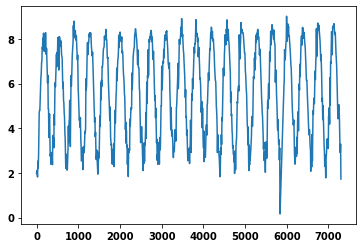

In [21]:
plt.plot(Mean_Daily_frame[:,1])

In [22]:
Mean_Daily_frame.shape

(7300, 95)

<font color="blue">**Calculate the monthly values of MEAN from daily values by summing up values with the same year and month [:7] per subbasin**

In [23]:
TM = np.arange(np.datetime64('2000-01'),np.datetime64('2020-01'),np.timedelta64(1,'M'))
Mean_Monthly_frame = np.zeros([np.size(TM),PET_per_sub_mean.shape[1]])

for sub in range(0,PET_per_sub_mean.shape[1]):
    for i in range(0,np.size(TM)):
        indexstr = TM[i].astype(str)
        A = 0
        for t in range(0,np.size(TI)):
            
            if (indexstr == TI[t].astype(str)[:7]):
                A = A + Mean_Daily_frame[t,sub]
            Mean_Monthly_frame[i,sub] = A

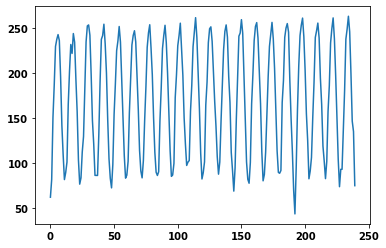

In [24]:
plt.plot(Mean_Monthly_frame[:,1])

In [25]:
Mean_Monthly_frame.shape

(240, 95)

<font color="blue">**Creating a dataframe for the monthly values of MEAN per subbasin**

In [26]:
PET_per_sub_mean_monthly = pd.DataFrame(Mean_Monthly_frame.round(3),index = TM,columns=PET_per_sub_mean.columns)
PET_per_sub_mean_monthly

,1,2,3,4,5,6,7,8,9,10,...,86,87,88,89,90,91,92,93,94,95
2000-01-01,64.008,62.341,61.221,61.203,60.910,61.711,63.157,59.959,67.098,62.795,...,NaN,63.454,61.408,69.790,68.323,69.200,61.879,69.584,NaN,68.887
2000-02-01,77.468,82.073,78.791,76.602,79.506,77.103,77.258,73.323,77.506,78.899,...,NaN,81.112,78.836,75.549,91.609,76.204,76.535,82.731,NaN,75.451
2000-03-01,138.759,151.025,141.380,137.916,146.890,139.282,138.231,141.045,146.047,144.613,...,NaN,148.077,146.845,145.810,148.297,142.302,142.339,130.376,NaN,145.105
2000-04-01,183.334,187.246,183.346,178.571,185.003,184.270,182.415,185.072,190.426,184.661,...,NaN,187.797,187.326,187.454,185.746,183.482,185.768,172.587,NaN,184.269
2000-05-01,222.694,229.921,224.412,220.574,223.447,220.832,216.884,219.347,223.155,220.126,...,NaN,221.473,223.965,213.743,223.395,208.966,219.662,206.672,NaN,210.701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,242.912,246.134,237.162,239.393,238.735,234.761,232.508,234.325,231.635,230.258,...,NaN,218.736,231.096,205.418,231.452,199.711,227.288,219.692,NaN,203.194
2019-09-01,197.021,199.631,191.372,195.256,195.043,193.157,188.811,189.501,191.426,186.563,...,NaN,177.272,188.554,165.522,187.546,161.242,186.191,179.853,NaN,163.475
2019-10-01,147.372,146.885,143.481,147.012,146.667,146.981,147.308,145.802,156.014,144.305,...,NaN,141.803,144.847,139.117,141.838,136.121,145.026,141.704,NaN,139.497
2019-11-01,137.578,135.278,133.610,138.101,137.036,137.634,138.874,135.353,145.034,134.995,...,NaN,132.345,134.449,138.732,129.454,140.060,137.741,136.602,NaN,139.805


<font color="blue">**Creating a dataframe for EVERY Subbasin with monthly values of MEAN**

<font color="blue">**Exporting all Mean Dataframes per Subbasin to .csv file**

In [27]:
PET_per_sub_mean_monthly.to_csv(os.path.join(output,'PET_mean_by_subbasin_month.csv'))
#ET_median.to_csv(os.path.join(output,'ET_median_by_subbasin.csv'))
#ET_count.to_csv(os.path.join(output,'ET_count_by_subbasin.csv'))
#ET_ratio_active_cells.to_csv(os.path.join(output,'ET_Ration_Active_cells_by_subbasin.csv'))